<a href="https://colab.research.google.com/github/vongkhmer/NoteOnEfficientCPP/blob/master/LIP_DATA_IEF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp /content/drive/My\ Drive/TrainVal_images.zip .
!unzip TrainVal_images.zip
!unzip TrainVal_images.zip
!rm -f TrainVal_images.zip
!cp /content/drive/My\ Drive/TrainVal_pose_annotations.zip .
!unzip TrainVal_pose_annotations.zip
!rm -f TrainVal_pose_annotations.zip
!mkdir preprocessed_train
!mkdir preprocessed_val

Streaming output truncated to the last 5000 lines.
  inflating: val_images/363752_453520.jpg  
  inflating: val_images/363764_1729006.jpg  
  inflating: val_images/363821_233103.jpg  
  inflating: val_images/363908_487436.jpg  
  inflating: val_images/363969_424153.jpg  
  inflating: val_images/363969_475685.jpg  
  inflating: val_images/363987_183746.jpg  
  inflating: val_images/364073_500662.jpg  
  inflating: val_images/364079_186955.jpg  
  inflating: val_images/364082_448563.jpg  
  inflating: val_images/364099_434163.jpg  
  inflating: val_images/364102_436084.jpg  
  inflating: val_images/364126_437585.jpg  
  inflating: val_images/364174_185563.jpg  
  inflating: val_images/364256_472681.jpg  
  inflating: val_images/364283_186906.jpg  
  inflating: val_images/364293_491867.jpg  
  inflating: val_images/364433_476433.jpg  
  inflating: val_images/364448_470179.jpg  
  inflating: val_images/364458_211998.jpg  
  inflating: val_images/36447_226298.jpg  
  inflating: val_images/3

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from os import listdir
from os.path import isfile, join
import cv2
import scipy.io 
import keras.backend as K

Image at: val_images/498630_900100498630.jpg
(416, 427, 3)


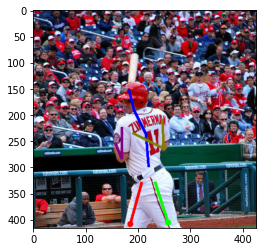

In [3]:
import csv
import sys
import random
import os
from PIL import Image, ImageDraw, ImageOps

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_joint(rec, img_folder):
  img_name = os.path.join(img_folder,rec[0])
  print('Image at: ' + img_name)
  img = Image.open(img_name)
  print(np.array(img).shape)
  draw = ImageDraw.Draw(img)
  r = 5
  bombs = [[0,1],[1,2]
			,[3,4],[4,5]
			,[6,7],[7,8],[8,9]
			,[10,11],[11,12]
			,[13,14], [14,15] ]
  colors = [(255,0,0),(255,0,0),
			  (0,255,0),(0,255,0),
			  (0,0,255),(0,0,255),(0,0,255),
			  (128,128,0),(128,128,0),
			  (128,0,128),(128,0,128)]
  r = 5 
  for b_id in range(len(bombs)):
    b = bombs[b_id]
    color = colors[b_id]
    x1 = rec[ b[0] * 3 + 1]
    y1 = rec[ b[0] * 3 + 2]
    v1 = rec[ b[0] * 3 + 3]
    
    x2 = rec[ b[1] * 3 + 1]
    y2 = rec[ b[1] * 3 + 2]
    v2 = rec[ b[1] * 3 + 3]
    
    if v1 != 'nan' and v2 != 'nan':
      draw.line((int(x1),int(y1), int(x2),int(y2)), fill = color, width = 5)
    elif v1 != 'nan':
      draw.ellipse((int(x1) - r, int(y1) - r, int(x1) + r, int(y1) + r), fill = color)
    elif v2 != 'nan':
      draw.ellipse((int(x2) - r, int(y2) - r, int(x2) + r, int(y2) + r), fill = color)
  plt.imshow(img)

def vis_anno(dataSet):
	csv_path = {
		'train': 'lip_train_set.csv' ,
		'valid': 'lip_val_set.csv',
		'test' :'lip_test_set.csv'
	}
	img_root = {
		'train': 'train_images/',
		'valid': 'val_images/',
		'test': 'notExist/',
	}
	with open(csv_path[dataSet]) as f:
		reader = csv.reader(f)
		recs = []
		for row in reader:
			recs.append(row)
		random_id = random.randint(0, len(recs) - 1)
		plot_joint(recs[random_id], img_root[dataSet])
  
dataSet = 'valid'
vis_anno(dataSet)


In [18]:
IMAGE_SHAPE=(200,200)
train_df = pd.DataFrame({"image_path":[], "joint_vector":[], "joint_valid":[]})
flip_pos = [(0,3), (1,4), (2,5), (10,13), (11,14), (12,15)]
with open("lip_train_set.csv") as f:
  reader = csv.reader(f)
  for row in reader:
    img_fn = os.path.join("train_images", row[0])
    print(img_fn)
    img = Image.open(img_fn)
    width, height = img.size
    img = img.resize(IMAGE_SHAPE)
    new_path = os.path.join("preprocessed_train", row[0])
    img.save(new_path)
    joint_vector = []
    joint_valid = []
    for i in range(16):
      pos_x = row[3*i + 1]
      pos_y = row[3*i + 2]
      exist = row[3*i + 3]
      if exist != 'nan':
        norm_x = (int(pos_x) - width // 2) / width
        norm_y = (int(pos_y) - height//2 ) / height
        joint_vector.append(norm_x)
        joint_vector.append(norm_y)
        joint_valid.append(1)
        joint_valid.append(1)
      else:
        joint_vector.append(0)
        joint_vector.append(0)
        joint_valid.append(0)
        joint_valid.append(0)

    train_df = train_df.append({"image_path":new_path, "joint_vector":np.array(joint_vector), "joint_valid":np.array(joint_valid)}, ignore_index=True)

    #mirroring
    flip_img = ImageOps.mirror(img)
    new_path = os.path.join("preprocessed_train", "flipped" + row[0])
    flip_img.save(new_path)
    for i in range(16):
      joint_vector[2*i] = - joint_vector[2*i]
    flip_joint_vector = joint_vector.copy()
    flip_joint_valid = joint_valid.copy()
    for fp in flip_pos:
      ind1 = fp[0]
      ind2 = fp[1]
      flip_joint_vector[2 * ind1] = joint_vector[2 * ind2]
      flip_joint_vector[2 * ind1 + 1] = joint_vector[2 * ind2 + 1]

      flip_joint_valid[2 * ind1] = joint_valid[2 * ind2]
      flip_joint_valid[2 * ind1 + 1] = joint_valid[2 * ind2 + 1]

      flip_joint_vector[2 * ind2] = joint_vector[2 * ind1]
      flip_joint_vector[2 * ind2 + 1] = joint_vector[2 * ind1 + 1]

      flip_joint_valid[2 * ind2] = joint_valid[2 * ind1]
      flip_joint_valid[2 * ind2 + 1] = joint_valid[2 * ind1 + 1]

    train_df = train_df.append({"image_path":new_path, "joint_vector":np.array(flip_joint_vector), "joint_valid":np.array(flip_joint_valid)}, ignore_index=True)

train_df


Streaming output truncated to the last 5000 lines.
train_images/537284_1679297.jpg
train_images/53729_1223996.jpg
train_images/537316_1713871.jpg
train_images/537326_496164.jpg
train_images/537367_1679697.jpg
train_images/537371_469153.jpg
train_images/5373_466269.jpg
train_images/537424_2162159.jpg
train_images/537506_498500.jpg
train_images/537512_251468.jpg
train_images/537520_474304.jpg
train_images/537532_509734.jpg
train_images/537548_183020.jpg
train_images/53756_441613.jpg
train_images/537617_199064.jpg
train_images/537656_516327.jpg
train_images/537667_463515.jpg
train_images/537673_494699.jpg
train_images/537687_1716620.jpg
train_images/537698_2229360.jpg
train_images/537698_425198.jpg
train_images/537701_481495.jpg
train_images/537765_450797.jpg
train_images/537770_470241.jpg
train_images/537770_516426.jpg
train_images/537773_183792.jpg
train_images/537780_468443.jpg
train_images/5377_1720030.jpg
train_images/537857_475645.jpg
train_images/537860_497995.jpg
train_images/5378

,image_path,joint_vector,joint_valid
0,preprocessed_train/1000_1234574.jpg,"[-0.11904761904761904, 0.3521739130434783, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,preprocessed_train/flipped1000_1234574.jpg,"[-0.23809523809523808, -0.008695652173913044, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,preprocessed_train/100111_470108.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,preprocessed_train/flipped100111_470108.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,preprocessed_train/10012_1730659.jpg,"[0.31683168316831684, 0.40066225165562913, 0.2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
60919,preprocessed_train/flipped99942_2160858.jpg,"[0.4791666666666667, -0.006779661016949152, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
60920,preprocessed_train/999_505943.jpg,"[0.38190954773869346, 0.28807947019867547, 0.1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
60921,preprocessed_train/flipped999_505943.jpg,"[0.07035175879396985, -0.3609271523178808, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
60922,preprocessed_train/999_506640.jpg,"[0.23076923076923078, 0.21105527638190955, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [19]:
val_df = pd.DataFrame({"image_path":[], "joint_vector":[], "joint_valid":[]})
with open("lip_val_set.csv") as f:
  reader = csv.reader(f)
  for row in reader:
    img_fn = os.path.join("val_images", row[0])
    img = Image.open(img_fn)
    width, height = img.size
    img = img.resize(IMAGE_SHAPE)
    new_path = os.path.join("preprocessed_val", row[0])
    img.save(new_path)
    joint_vector = []
    joint_valid = []
    for i in range(16):
      pos_x = row[3*i + 1]
      pos_y = row[3*i + 2]
      exist = row[3*i + 3]
      if exist != 'nan':
        norm_x = (int(pos_x) - width // 2) / width
        norm_y = (int(pos_y) - height//2 ) / height
        joint_vector.append(norm_x)
        joint_vector.append(norm_y)
        joint_valid.append(1)
        joint_valid.append(1)
      else:
        joint_vector.append(0)
        joint_vector.append(0)
        joint_valid.append(0)
        joint_valid.append(0)

    val_df = val_df.append({"image_path":new_path, "joint_vector":np.array(joint_vector), "joint_valid":np.array(joint_valid)}, ignore_index=True)
val_df

,image_path,joint_vector,joint_valid
0,preprocessed_val/100034_483681.jpg,"[0.32085561497326204, 0.3309692671394799, 0.15...","[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,preprocessed_val/10005_205677.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."
2,preprocessed_val/100142_449784.jpg,"[-0.32335329341317365, 0.38301886792452833, -0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,preprocessed_val/10014_1211482.jpg,"[0.019230769230769232, 0.38321167883211676, -0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,preprocessed_val/10024_490664.jpg,"[-0.13740458015267176, 0.3543859649122807, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
9995,preprocessed_val/9960_488732.jpg,"[-0.3287671232876712, 0.2922077922077922, -0.1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9996,preprocessed_val/99681_521075.jpg,"[-0.045112781954887216, 0.4090909090909091, 0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9997,preprocessed_val/99807_183413.jpg,"[-0.1794871794871795, 0.38738738738738737, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9998,preprocessed_val/99938_1719104.jpg,"[-0.19747899159663865, 0.3041825095057034, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [7]:
def plot_nomalized_joint(img_arr, joint_vector, joint_valid, draw_line = True, plot_title=None):
  if np.max(img_arr) < 2:
    img_arr = np.array(img_arr) * 255.0
    img_arr = img_arr.astype(np.uint8)
  img = Image.fromarray(img_arr)
  draw = ImageDraw.Draw(img)
  r = 5
  height, width, _ = img_arr.shape
  bombs = [[0,1],[1,2]
			,[3,4],[4,5]
			,[6,7],[7,8],[8,9]
			,[10,11],[11,12]
			,[13,14],[14,15]]
  colors = [(255,0,0),(255,0,0),
			  (0,255,0),(0,255,0),
			  (0,0,255),(0,0,255),(0,0,255),
			  (128,128,0),(128,128,0),
			  (128,0,128),(128,0,128)]
  r = 5 
  for b_id in range(len(bombs)):
    b = bombs[b_id]
    color = colors[b_id]
    x1 = joint_vector[2 * b[0]]
    x1 = x1 * width + width // 2
    y1 = joint_vector[2 * b[0] + 1]
    y1 = y1 * height + height // 2
    v1 = joint_valid[2 * b[0]]
    
    x2 = joint_vector[2 * b[1]]
    x2 = x2 * width + width //2
    y2 = joint_vector[2 * b[1] + 1]
    y2 = y2 * height + height // 2
    v2 = joint_valid[2 * b[1]]
    
    if v1 != 0 and v2 != 0:
      if draw_line :
        draw.line((int(x1),int(y1), int(x2),int(y2)), fill = color, width = 5)
      draw.ellipse((int(x1) - r, int(y1) - r, int(x1) + r, int(y1) + r), fill = color)
      draw.ellipse((int(x2) - r, int(y2) - r, int(x2) + r, int(y2) + r), fill = color)
    elif v1 != 0:
      draw.ellipse((int(x1) - r, int(y1) - r, int(x1) + r, int(y1) + r), fill = color)
    elif v2 != 0:
      draw.ellipse((int(x2) - r, int(y2) - r, int(x2) + r, int(y2) + r), fill = color)
  plt.imshow(img)
  if plot_title != None:
    plt.title(plot_title)
  plt.show()

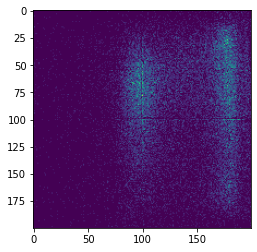

In [52]:
import math
joint_distr = np.zeros((200,200,16))
joint_total = np.zeros((16))
for i in range(60924):
  jve = train_df.loc[i]["joint_vector"]
  jva = train_df.loc[i]["joint_valid"]
  for j in range(16):
    if jva[2*j]:
      x = math.floor(jve[2*j] * IMAGE_SHAPE[0]) + IMAGE_SHAPE[0] // 2
      y = math.floor(jve[2*j+1] * IMAGE_SHAPE[1]) + IMAGE_SHAPE[1] // 2
      if x < 0 or x >= IMAGE_SHAPE[0] or y < 0 or y >= IMAGE_SHAPE[1]:
          continue
      joint_distr[x,y,j] = joint_distr[x,y,j]+ 1.0
      joint_total[j] = joint_total[j] + 1.0

for j in range(16):
  joint_distr[:,:,j] = joint_distr[:,:,j] / joint_total[j]

index = 0

plt.imshow(joint_distr[:,:,index])
plt.show()


In [61]:
average_joint_chanels = tf.convert_to_tensor(joint_distr, dtype=tf.float32)
print(average_joint_chanels)

tf.Tensor(
[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 3.7837224e-05 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.1502601e-05
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.1502601e-05
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 3.6599202e-05 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 7.567444

(32,)


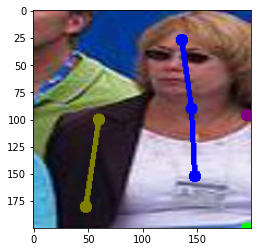

In [29]:
test_index = 369
img = train_df.loc[test_index]["image_path"]
img_arr = np.array(Image.open(img))
joint_vector = train_df.loc[test_index]["joint_vector"]
joint_valid = train_df.loc[test_index]["joint_valid"]
print(joint_vector.shape)
#print(img)
#print(joint_vector)
plot_nomalized_joint(img_arr, joint_vector, joint_valid)

In [62]:
image_path = train_df["image_path"]
joint_vector = train_df["joint_vector"]
joint_vector = np.stack(joint_vector)
print(joint_vector.shape)
joint_valid = train_df["joint_valid"]
joint_valid = np.stack(joint_valid)

data_dict = {"image_path":image_path, "joint_vector":joint_vector, "joint_valid":joint_valid}

train_data = tf.data.Dataset.from_tensor_slices(data_dict)

val_image_path = val_df["image_path"]
val_joint_vector = val_df["joint_vector"]
val_joint_vector = np.stack(val_joint_vector)
print(val_joint_vector.shape)
val_joint_valid = val_df["joint_valid"]
val_joint_valid = np.stack(val_joint_valid)

val_data_dict = {"image_path":val_image_path, "joint_vector":val_joint_vector, "joint_valid":val_joint_valid}

train_data = tf.data.Dataset.from_tensor_slices(data_dict)
val_data = tf.data.Dataset.from_tensor_slices(val_data_dict)

def preprocess(image_info):
  image_path = image_info["image_path"]
  joint_vector = image_info["joint_vector"]
  joint_valid = image_info["joint_valid"]
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image_shape = tf.shape(image)
  if image_shape[-1] < 3 :
    image = tf.image.grayscale_to_rgb(image)
  image = tf.concat([image, average_joint_chanels], axis=-1)
  return (image, joint_valid), joint_vector

train_data = train_data.shuffle(buffer_size=60924, seed=72, reshuffle_each_iteration=False)
train_data = train_data.map(preprocess, num_parallel_calls=2)
val_data = val_data.map(preprocess, num_parallel_calls=2)
train_data_iter = iter(train_data)
val_data_iter = iter(val_data)

(60924, 32)
(10000, 32)


(200, 200, 19)


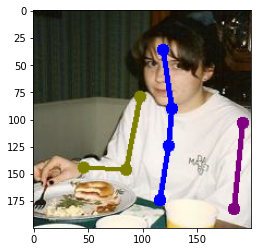

In [72]:
(img_arr, jva), jve = next(train_data_iter)
print(np.array(img_arr).shape)
plot_nomalized_joint(img_arr[:,:,0:3], jve, jva)

In [73]:
def euclidean_distance_loss(y_true, y_pred):
    #can I add joint_valid_info here??
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

def cust_loss(y,y_pred):
  return tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(y, y_pred)), 1))

input_tensor = tf.keras.layers.Input(shape=(200,200,19))

x = tf.keras.layers.Conv2D(filters=48,kernel_size=(3,3), padding="same", activation="relu")(input_tensor)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=128,kernel_size=(5,5), activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=256,kernel_size=(7,7), activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=256,kernel_size=(7,7), activation="relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32)(x)
open_model = tf.keras.Model(inputs=input_tensor, outputs=x)
open_model.summary()

open_model.compile(optimizer=tf.keras.optimizers.Adagrad(), loss=tf.keras.lo)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 19)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 48)      8256      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 48)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 128)       153728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 256)       1605888   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 256)      

In [ ]:
input_tensor = tf.keras.layers.Input(shape=(200,200,19))
out1 = open_model(input_tensor)
img = tf.slice(input_tensor, [0,0, 0, 0], [-1, -1, -1, 3])
for i in range(16):
  jv = tf.slice(out1, [0,2*i], [-1,2])
  jv = tf.reshape(jv, shape=(-1, 1,1,2))
  new_chanel = joint_to_chanel(jv)
  img = tf.concat([img, new_chanel], axis=-1)

out2 = open_model(img)

img = tf.slice(input_tensor, [0,0, 0, 0], [-1, -1, -1, 3])
for i in range(16):
  jv = tf.slice(out2, [0,2*i], [-1,2])
  jv = tf.reshape(jv, shape=(-1, 1,1,2))
  new_chanel = joint_to_chanel(jv)
  img = tf.concat([img, new_chanel], axis=-1)
  
out3 = open_model(img)

close_model = tf.keras.Model(inputs=input_tensor, outputs=[out1, out2, out3])
close_model.summary())

In [ ]:
batch_size = 64
EPOCH = 10
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(2)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(2)
training_hist = []
val_hist = []

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch % 10 == 0:
      loss = logs.get('loss')
      val_loss = logs.get('val_loss')
      print("loss at epoch", epoch, loss, "val_loss", val_loss)

    if  epoch % 50 == 0:
      self.model.save("drive/My Drive/LIP_VGG_MODELS/big_filter_model_epoch_" + str(epoch) + ".h5")

callback1 = MyCustomCallback()
history = big_filter_pose_model.fit(train_data, validation_data=val_data, verbose=0, epochs=301, callbacks=[callback1])

training_hist = training_hist + history.history["loss"]
val_hist = val_hist + history.history["val_loss"]


In [ ]:
plt.plot(training_hist, label="loss")
plt.plot(val_hist, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
big_filter_pose_model.save("drive/My Drive/LIP_VGG_MODELS/big_filter_model_500.h5")

As we can see here, pixel regression have difficulty generalizing


In [ ]:
model_50 = tf.keras.models.load_model("drive/My Drive/LIP_VGG_MODELS/vggmodel_epoch_50.h5", custom_objects={"cust_loss":cust_loss})
model_500 = tf.keras.models.load_model("drive/My Drive/LIP_VGG_MODELS/vggmodel_epoch_450.h5", custom_objects={"cust_loss":cust_loss})
train_data_iter = iter(train_data)
val_data_iter = iter(val_data)



In [ ]:
X, Y = next(train_data_iter)
prediction1 = model_500.predict(X)

test_images = np.array(X[0])
bool_joint = np.array(X[1])
joint_vector_truth = np.array(Y)
test_index = np.random.randint(0,64)
plot_nomalized_joint(test_images[test_index], joint_vector_truth[test_index], bool_joint[test_index])
plot_nomalized_joint(test_images[test_index], prediction1[test_index], bool_joint[test_index])

Good performance on training set

In [ ]:
X, Y = next(val_data_iter)
prediction1 = model_500.predict(X)

test_images = np.array(X[0])
bool_joint = np.array(X[1])
joint_vector_truth = np.array(Y)
test_index = np.random.randint(0,64)
plot_nomalized_joint(test_images[test_index], joint_vector_truth[test_index], bool_joint[test_index])
plot_nomalized_joint(test_images[test_index], prediction1[test_index], bool_joint[test_index])

Bad performance on valdiation set


In [ ]:
model_100 = tf.keras.models.load_model("drive/My Drive/LIP_VGG_MODELS/vggmodel_epoch_100.h5", custom_objects={"cust_loss":cust_loss})
train_data_iter = iter(train_data)
val_data_iter = iter(val_data)

In [ ]:
X, Y = next(train_data_iter)
prediction1 = model_100.predict(X)
prediction2 = model_500.predict(X)

test_images = np.array(X[0])
bool_joint = np.array(X[1])
joint_vector_truth = np.array(Y)
test_index = np.random.randint(0,64)
plot_nomalized_joint(test_images[test_index], joint_vector_truth[test_index], bool_joint[test_index], plot_title="Ground_truth")
plot_nomalized_joint(test_images[test_index], prediction1[test_index], bool_joint[test_index], plot_title="Mode_100")
plot_nomalized_joint(test_images[test_index], prediction2[test_index], bool_joint[test_index], plot_title="Model_500")

Model100 underfits!


In [ ]:
X, Y = next(val_data_iter)
prediction1 = model_100.predict(X)
prediction2 = model_500.predict(X)

test_images = np.array(X[0])
bool_joint = np.array(X[1])
joint_vector_truth = np.array(Y)
test_index = np.random.randint(0,64)
plot_nomalized_joint(test_images[test_index], joint_vector_truth[test_index], bool_joint[test_index], plot_title="Ground_truth")
plot_nomalized_joint(test_images[test_index], prediction1[test_index], bool_joint[test_index], plot_title="Mode_100")
plot_nomalized_joint(test_images[test_index], prediction2[test_index], bool_joint[test_index], plot_title="Model_500")